# **1. Import thư viện**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from glob import glob
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CÔNG CỤ LẬP TRÌNH AI/DATA')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/CÔNG CỤ LẬP TRÌNH AI/DATA/cats_vs_rabbits.zip"

with ZipFile(file_name, 'r') as zip:
    # In ra tất cả nội dung có trong file zip
    zip.printdir()
    # Giải nén tất cả các tệp tin trong file
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
test-images/cat/cat.208.jpg                    2021-07-28 19:05:04        44504
test-images/cat/cat.209.jpg                    2021-07-28 19:05:04        53693
test-images/cat/cat.210.jpg                    2021-07-28 19:05:04        33825
test-images/cat/cat.233.jpg                    2021-07-28 19:05:04        36963
test-images/cat/cat.234.jpg                    2021-07-28 19:05:04        24239
test-images/cat/cat.235.jpg                    2021-07-28 19:05:04        21934
test-images/cat/cat.236.jpg                    2021-07-28 19:05:04        39428
test-images/cat/cat.237.jpg                    2021-07-28 19:05:04        48895
test-images/cat/cat.238.jpg                    2021-07-28 19:05:04        42672
test-images/cat/cat.239.jpg                    2021-07-28 19:05:04        35167
test-images/rabbit/images-2.jpeg               2021-07-28 19:05:04         5993
test-images/rabbit/images-3.jpeg        

# **2. Tiền xử lý**

In [ ]:
train_path = "train-cat-rabbit/"
valid_path = "val-cat-rabbit/"
test_path = "test-images/"

In [ ]:
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

print("{:15} : {}".format("Class Names", class_names))
print("{:15} : {}".format("No. of Classes", n_classes))

Class Names     : ['cat', 'rabbit']
No. of Classes  : 2


## **a. Load Data**

In [ ]:
def collect_imagepaths(main_dir_path: str, class_names: list, shuffle: bool = True) -> list:
    all_filepaths = []
    valid_extensions = ('.jpg', '.jpeg')
    for class_name in tqdm(class_names, desc='Collecting image paths'):
        class_dir_path = os.path.join(main_dir_path, class_name)
        class_file_paths = sorted(glob(os.path.join(class_dir_path, "*")))
        for file_path in class_file_paths:
            if os.path.splitext(file_path)[1].lower() in valid_extensions:
                all_filepaths.append(file_path)
    if shuffle:
        np.random.shuffle(all_filepaths)
    return all_filepaths

In [ ]:
train_data = collect_imagepaths(train_path, class_names, shuffle=True)
valid_data = collect_imagepaths(valid_path, class_names, shuffle=True)
test_data  = collect_imagepaths(test_path,  class_names, shuffle=True)

In [ ]:
print('Train Images:',len(train_data))
print('Validation Images:',len(valid_data))
print('Test Images:',len(test_data))

Train Images: 1600
Validation Images: 414
Test Images: 15


## **b. Kiểm tra kích cỡ của ảnh**



In [ ]:
img = cv2.imread(str(train_data[1]))
img.shape

(300, 300, 3)

**Kích cỡ hiện tại của các bức ảnh là (300, 300, 3) ta cần chuyển về (224, 224, 3)**

In [ ]:
# Tải hình ảnh mong muốn và resize ảnh, màu và chuyển đổi nó thành Tensorflow 32Bit-float Tensor
img_size = (224, 224)
def prepare_image(image_path, size = img_size, normalize:bool = True):
    image = cv2.imread(image_path)# gọi hình ảnh
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)# chuẩn hóa màu từ BGR sang RGB
    image = cv2.resize(image, size, cv2.INTER_AREA)# chuẩn hóa kích thước hình ảnh theo kích thước mong muốn
    image = tf.cast(image, tf.float32)# chuẩn hóa hình ảnh thành Tensorflow 32Bit-float Tensor
    if normalize:
        image = image/255.0
    return image


In [ ]:
class_index_map = {name:index for index, name in enumerate(class_names)}
class_index_map

{'cat': 0, 'rabbit': 1}

In [ ]:
# Hàm dùng đế tách và lấy nhãn của lớp:
def get_label(path:str, mapping:dict) -> int:
    label = path.split("/")[-2] # tách đường dẵn để lấy tên lớp
    label = mapping[label] #lấy nhãn lớp
    return label

In [ ]:
# Tải nhiều hình ảnh & Nhãn và tạo tập dữ liệu.
batch_size = 32
def prepare_DataSet(paths, mapping, size = img_size, tf_data=False, BATCH_SIZE=batch_size):
    images = np.empty(shape=(len(paths), *size, 3), dtype=np.float32) # hình ảnh
    labels = np.empty(shape=(len(paths), 1), dtype=np.int32) # nhãn
    index = 0
    for path in tqdm(paths, desc="Loading"):
        image = prepare_image(image_path=path, size=size, normalize=True) #thu thập ảnh
        label = get_label(path=path, mapping=mapping)# thu thập nhãn
        images[index] = image
        labels[index] = label
        index += 1
    # Trả về tập dữ liệu Tensorflow
    if tf_data:
        tf_ds = tf.data.Dataset.from_tensor_slices((images, labels))
        tf_ds = tf_ds.cache().shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
        tf_ds = tf_ds.prefetch(tf.data.AUTOTUNE)
        return (images, labels), tf_ds
    return images, labels

In [ ]:
# Load Training Data
(train_images, train_labels), train_set = prepare_DataSet(paths=train_data, mapping=class_index_map, tf_data=True)
# Load Validation Data
(valid_images, valid_labels), valid_set = prepare_DataSet(paths=valid_data, mapping=class_index_map, tf_data=True)
# Load Testing Data
(test_images, test_labels), test_set  = prepare_DataSet(paths=test_data, mapping=class_index_map, tf_data=True)

Loading: 100%|██████████| 15/15 [00:00<00:00, 178.20it/s]


In [ ]:
train_set, valid_set, test_set

(<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.int32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.int32, name=None))>)

## **c. Kiểm tra xem các ảnh đã nằm đúng mục hay chưa**


In [ ]:
def show_images(images: list, labels: list, class_names: list, model: None = None, SoLuong: tuple = (10,10), SIZE: tuple = (30,25)) -> None:
    plt.figure(figsize=SIZE)
    n_rows = SoLuong[0]
    n_cols = SoLuong[1]
    n_images = n_rows * n_cols
    count = 0

    while count < n_images:
        index = count % len(images)
        image, label = images[index], labels[index]
        title = class_names[int(label)]

        if model is not None:
            image = tf.expand_dims(tf.cast(image, tf.float32), axis=0)
            proba = model.predict(image)
            pred  = class_names[int(np.round(proba))]
            title = "True : {}\nPred : {}".format(title, pred)

        plt.subplot(n_rows, n_cols, count+1)
        plt.imshow(tf.squeeze(image))
        plt.title(title.title())
        plt.axis('off')

        count += 1

    plt.show()


In [ ]:
show_images(train_images, train_labels, class_names=class_names)

Output hidden; open in https://colab.research.google.com to view.

## **d. Sinh ảnh**

In [ ]:
data_aug = keras.models.Sequential(layers=[
    keras.layers.Input(shape=(224, 224, 3), name = "InputLayer"),
    keras.layers.RandomFlip(mode = 'horizontal_and_vertical', name = "RandomFlip"),
    keras.layers.RandomRotation(factor = 10, fill_mode = 'reflect', name = "RandomRotation"),
    keras.layers.RandomContrast(factor = 0.5, name = "RandomContrast")], name = "DataAugmetor")

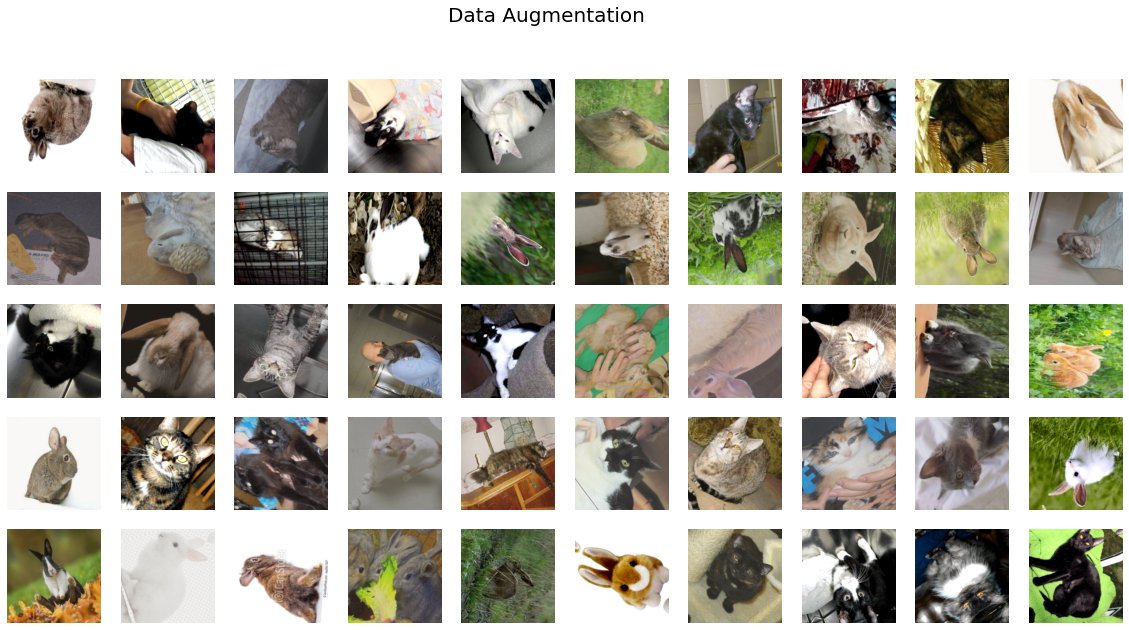

In [ ]:
aug_images = data_aug(train_images[:50])

plt.figure(figsize=(20,10))
plt.suptitle("Data Augmentation", fontsize=20)
for i in range(len(aug_images)):
    plt.subplot(5,10,i+1)
    plt.imshow(aug_images[i])
    plt.axis('off')
plt.show()

# **3. Xây dựng, đánh giá mô hình và kiểm thử**

## **VGG19**

In [ ]:
model_name = 'VGG19'

pretrained_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

pretrained_model.trainable = True

vgg19_model = keras.models.Sequential([
    keras.layers.Input(shape=(224,224,3)),
    data_aug,
    pretrained_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

# Model Summary
vgg19_model.summary()
# Compile Model
vgg19_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
# Model Callbacks
callbacks = [
    # keras.callbacks.EarlyStopping(patience=3, monitor = 'val_accuracy', restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(model_name+".h5", monitor = "val_accuracy", save_best_only=True)
]
# Model Training
history = vgg19_model.fit(train_set, validation_data=valid_set, callbacks=callbacks, epochs=10)

80134624/80134624 [==============================] - 4s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DataAugmetor (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


50/50 [==============================] - 67s 859ms/step - loss: 0.6857 - accuracy: 0.5819 - val_loss: 0.5741 - val_accuracy: 0.6875
Epoch 2/10
50/50 [==============================] - 41s 818ms/step - loss: 0.5251 - accuracy: 0.7487 - val_loss: 0.5988 - val_accuracy: 0.6979
Epoch 3/10
50/50 [==============================] - 35s 690ms/step - loss: 0.4718 - accuracy: 0.7869 - val_loss: 0.5134 - val_accuracy: 0.7474
Epoch 4/10
50/50 [==============================] - 39s 773ms/step - loss: 0.4292 - accuracy: 0.8112 - val_loss: 0.4347 - val_accuracy: 0.7943
Epoch 5/10
50/50 [==============================] - 37s 750ms/step - loss: 0.3865 - accuracy: 0.8281 - val_loss: 0.3960 - val_accuracy: 0.8151
Epoch 6/10
50/50 [==============================] - 35s 691ms/step - loss: 0.3609 - accuracy: 0.8444 - val_loss: 0.4152 - val_accuracy: 0.7995
Epoch 7/10
50/50 [==============================] - 37s 747ms/step - loss: 0.3654 - accuracy: 0.8381 - val_loss: 0.3994 - val_accuracy: 0.8229
Epoch 8/10

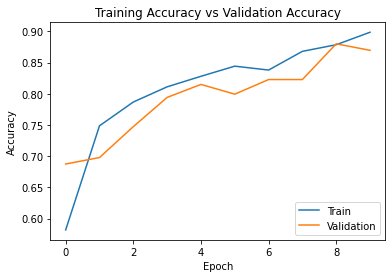

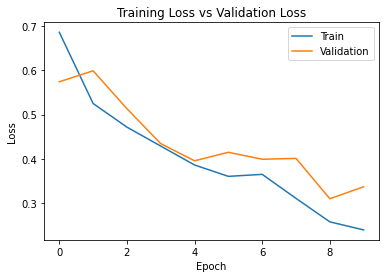

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
VGG19_train = vgg19_model.evaluate(train_images, train_labels)

50/50 [==============================] - 8s 154ms/step - loss: 0.1899 - accuracy: 0.9200


In [ ]:
VGG19_test = vgg19_model.evaluate(test_images, test_labels)

1/1 [==============================] - 2s 2s/step - loss: 0.2125 - accuracy: 0.9333


In [ ]:
VGG19_valid = vgg19_model.evaluate(valid_images, valid_labels)

13/13 [==============================] - 5s 379ms/step - loss: 0.3465 - accuracy: 0.8696


In [ ]:
y_pred = vgg19_model.predict(test_images)

1/1 [==============================] - 0s 308ms/step


In [ ]:
y_pred = np.where(y_pred > 0.5, 1,0)
len(y_pred)

15

In [ ]:
y_true = test_labels
len(y_true)

15

In [ ]:
y_true.reshape((-1))

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [ ]:
metrics_acc = tf.keras.metrics.Accuracy()
metrics_acc.update_state(y_true,y_pred)
metrics_acc.result().numpy()

0.93333334

In [ ]:
accuracy_score(y_true, y_pred)

0.9333333333333333

In [ ]:
labels = ['cat','rabbit']

In [ ]:
print(classification_report(y_true,y_pred,target_names=labels))

              precision    recall  f1-score   support

         cat       0.91      1.00      0.95        10
      rabbit       1.00      0.80      0.89         5

    accuracy                           0.93        15
   macro avg       0.95      0.90      0.92        15
weighted avg       0.94      0.93      0.93        15



In [ ]:
show_images(valid_images, valid_labels, class_names=class_names, model = vgg19_model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_images(test_images, test_labels, class_names=class_names, model = vgg19_model)

Output hidden; open in https://colab.research.google.com to view.

## **ResNet50V2**

In [ ]:
model_name = 'ResNet50v2'

pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

pretrained_model.trainable = True

resnet_model = keras.models.Sequential([
    keras.layers.Input(shape=(224,224,3), name = 'input'),
    data_aug,
    keras.layers.BatchNormalization(),
    pretrained_model,
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid', name = 'output'),
])

# Model Summary
resnet_model.summary()
# Compile Model
resnet_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    metrics=['accuracy']
)
# Model Callbacks
callbacks = [
    # keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(model_name+".h5", monitor="val_accuracy", save_best_only=True)
]

# Model Training
history = resnet_model.fit(train_set, validation_data=valid_set, callbacks=callbacks, epochs=10)

94668760/94668760 [==============================] - 5s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DataAugmetor (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                      

50/50 [==============================] - 71s 727ms/step - loss: 0.2316 - accuracy: 0.9013 - val_loss: 0.1932 - val_accuracy: 0.9479
Epoch 2/10
50/50 [==============================] - 24s 489ms/step - loss: 0.0758 - accuracy: 0.9750 - val_loss: 0.2281 - val_accuracy: 0.9375
Epoch 3/10
50/50 [==============================] - 29s 582ms/step - loss: 0.0565 - accuracy: 0.9837 - val_loss: 0.1421 - val_accuracy: 0.9635
Epoch 4/10
50/50 [==============================] - 29s 583ms/step - loss: 0.0384 - accuracy: 0.9856 - val_loss: 0.0727 - val_accuracy: 0.9766
Epoch 5/10
50/50 [==============================] - 24s 489ms/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.0803 - val_accuracy: 0.9688
Epoch 6/10
50/50 [==============================] - 24s 483ms/step - loss: 0.0310 - accuracy: 0.9906 - val_loss: 0.1106 - val_accuracy: 0.9609
Epoch 7/10
50/50 [==============================] - 28s 570ms/step - loss: 0.0326 - accuracy: 0.9919 - val_loss: 0.0606 - val_accuracy: 0.9844
Epoch 8/10

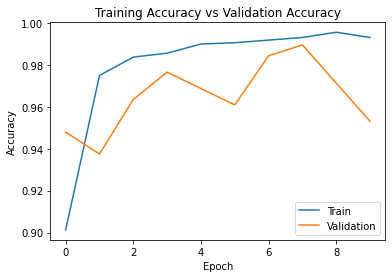

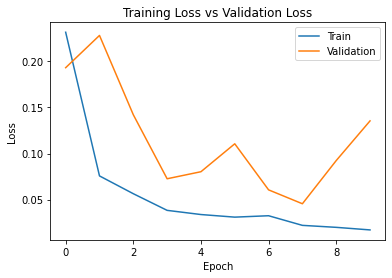

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
resnet_train = resnet_model.evaluate(train_images, train_labels)

50/50 [==============================] - 5s 93ms/step - loss: 0.0099 - accuracy: 0.9969


In [ ]:
resnet_test = resnet_model.evaluate(test_images, test_labels)

1/1 [==============================] - 2s 2s/step - loss: 0.0048 - accuracy: 1.0000


In [ ]:
resnet_valid = resnet_model.evaluate(valid_images, valid_labels)

13/13 [==============================] - 2s 180ms/step - loss: 0.1288 - accuracy: 0.9541


In [ ]:
y_pred = resnet_model.predict(test_images)

1/1 [==============================] - 0s 34ms/step


In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
len(y_pred)

15

In [ ]:
y_true = test_labels
len(y_true)

15

In [ ]:
y_true.reshape((-1))

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [ ]:
metrics_acc = tf.keras.metrics.Accuracy()
metrics_acc.update_state(y_true,y_pred)
metrics_acc.result().numpy()

1.0

In [ ]:
accuracy_score(y_true, y_pred)

1.0

In [ ]:
labels = ['cat', 'rabbit']

In [ ]:
print(classification_report(y_true,y_pred,target_names=labels))

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        10
      rabbit       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [ ]:
show_images(valid_images, valid_labels, class_names=class_names, model = resnet_model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_images(test_images, test_labels, class_names=class_names, model = resnet_model)

Output hidden; open in https://colab.research.google.com to view.

## **MobileNetV1**

In [ ]:
model_name = 'MobileNet_v1'

pretrained_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet')

pretrained_model.trainable = True

mobilenet_model = keras.models.Sequential([
    keras.layers.Input(shape=(224,224,3)),
    data_aug,
    keras.layers.BatchNormalization(),
    pretrained_model,
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

# Model Summary
mobilenet_model.summary()
# Compile Model
mobilenet_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)
# Model Callbacks
callbacks = [
    # keras.callbacks.EarlyStopping(patience=3, monitor = 'val_accuracy', restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(model_name+".h5", monitor = "val_accuracy", save_best_only=True)
]
# Model Training
history = mobilenet_model.fit(train_set, validation_data=valid_set, callbacks=callbacks, epochs=10)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DataAugmetor (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 3)      12        
 hNormalization)                                                 
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 1024)       4096      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                             

50/50 [==============================] - 36s 334ms/step - loss: 0.2002 - accuracy: 0.9225 - val_loss: 0.9189 - val_accuracy: 0.6953
Epoch 2/10
50/50 [==============================] - 17s 330ms/step - loss: 0.0647 - accuracy: 0.9800 - val_loss: 0.6864 - val_accuracy: 0.7734
Epoch 3/10
50/50 [==============================] - 17s 351ms/step - loss: 0.0342 - accuracy: 0.9912 - val_loss: 0.3762 - val_accuracy: 0.8672
Epoch 4/10
50/50 [==============================] - 16s 329ms/step - loss: 0.0323 - accuracy: 0.9862 - val_loss: 0.0784 - val_accuracy: 0.9766
Epoch 5/10
50/50 [==============================] - 15s 299ms/step - loss: 0.0197 - accuracy: 0.9950 - val_loss: 0.1475 - val_accuracy: 0.9505
Epoch 6/10
50/50 [==============================] - 15s 296ms/step - loss: 0.0270 - accuracy: 0.9944 - val_loss: 0.1562 - val_accuracy: 0.9427
Epoch 7/10
50/50 [==============================] - 15s 296ms/step - loss: 0.0342 - accuracy: 0.9881 - val_loss: 0.1664 - val_accuracy: 0.9323
Epoch 8/10

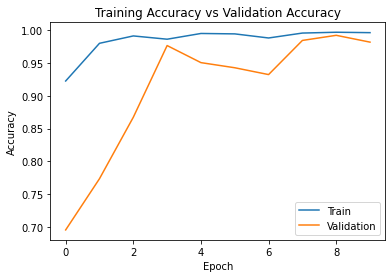

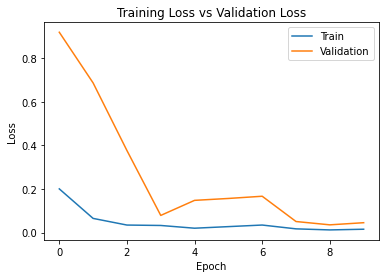

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
mobilenet_train = mobilenet_model.evaluate(train_images, train_labels)

50/50 [==============================] - 2s 38ms/step - loss: 0.0021 - accuracy: 1.0000


In [ ]:
mobilenet_test = mobilenet_model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 50ms/step - loss: 1.4306e-04 - accuracy: 1.0000


In [ ]:
mobilenet_valid = mobilenet_model.evaluate(valid_images, valid_labels)

13/13 [==============================] - 1s 53ms/step - loss: 0.0464 - accuracy: 0.9807


In [ ]:
y_pred = mobilenet_model.predict(test_images)

1/1 [==============================] - 1s 673ms/step


In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
len(y_pred)

15

In [ ]:
y_true = test_labels
len(y_true)

15

In [ ]:
y_true.reshape((-1))

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [ ]:
metrics_acc = tf.keras.metrics.Accuracy()
metrics_acc.update_state(y_true,y_pred)
metrics_acc.result().numpy()

1.0

In [ ]:
accuracy_score(y_true, y_pred)

1.0

In [ ]:
labels = ['cat', 'rabbit']

In [ ]:
print(classification_report(y_true,y_pred,target_names=labels))

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        10
      rabbit       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [ ]:
show_images(valid_images, valid_labels, class_names=class_names, model = mobilenet_model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_images(test_images, test_labels, class_names=class_names, model = mobilenet_model)

Output hidden; open in https://colab.research.google.com to view.

##**Đánh giá hiệu quả của mô hình**

In [ ]:
import seaborn as sns
pd.set_option('display.precision',10)
compare_table=pd.DataFrame([VGG19_test, resnet_test, mobilenet_test],columns=['Loss','Accuracy'], index=['VGG19','ResNet50V2','MobileNetV1'])
cm = sns.light_palette("red", as_cmap=True)
compare_table.head().style.background_gradient(cmap=cm)

,Loss,Accuracy
VGG19,0.212512,0.933333
ResNet50V2,0.004809,1.000000
MobileNetV1,0.000143,1.000000


Từ kết quả so sánh giữa 3 mô hình VGG19, ResNet50V2 và MobileNetV1 ở trên ta rút ra được kết luận rằng:

- Cả 3 mô hình đều đạt được độ chính xác ở mức cao, nhưng VGG19 vẫn còn sai sót ở một vài hình ảnh.
- Tuy nhiên thì mô hình MobileNetV1 có số params nhỏ nhất và điều này sẽ giúp ta tiết kiệm được chi phí bộ nhớ để lưu mô hình

=> Vậy mô hình tối ưu nhất ở đây là: **MobileNetV1**